In [1]:
import numpy               as np
import matplotlib.pyplot   as plt
import matplotlib.pyplot   as pp # we will merge these
import pandas              as pd
import seaborn             as sb

from datetime              import timedelta, datetime

from sklearn               import metrics
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn.mixture       import GaussianMixture
from sklearn.linear_model  import LinearRegression

from matplotlib.colors     import LogNorm

from IPython.display       import HTML, Markdown

from sklearn.metrics       import mean_squared_error

%matplotlib inline

np.random.seed(0)

import os
print(os.listdir("./input"))

['historical_transactions.csv', '.ipynb_checkpoints', 'new_merchant_transactions.csv', '.~lock.Data_Dictionary.xlsx#', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'Data_Dictionary.xlsx', '.gitignore', 'train.csv']


## Read in all the data files

In [3]:
train        = pd.read_csv('input/train.csv', parse_dates=['first_active_month']).set_index('card_id')
test         = pd.read_csv('input/test.csv',  parse_dates=['first_active_month']).set_index('card_id')
merchants    = pd.read_csv('input/merchants.csv').set_index('merchant_id')
transactions_old = pd.read_csv('input/historical_transactions.csv',   parse_dates = ['purchase_date'])
transactions_new = pd.read_csv('input/new_merchant_transactions.csv', parse_dates = ['purchase_date'])

## Data Clean Up

In [4]:
# Row is missing value for first_active_month
print(test.loc['C_ID_c27b4f80f7', :])
test = test.drop(index='C_ID_c27b4f80f7')

first_active_month    NaT
feature_1               5
feature_2               2
feature_3               1
Name: C_ID_c27b4f80f7, dtype: object


# Exploratory Data Analysis

In [5]:
mark('<b>Code Book for Training Data</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'train', header = 2).style.hide_index())
line()

mark('<b>Code Book for Historical Transactions</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'history', header = 2).style.hide_index())
line()

mark('<b>Code Book for New Merchant Transactions</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'new_merchant_period', header = 2).style.hide_index())
line()

mark('<b>Code Book for Merchant Details</b>')
display(pd.read_excel('input/Data_Dictionary.xlsx', sheet_name = 'merchant', header = 2).style.hide_index())

<b>Code Book for Training Data</b>

Columns,Description
card_id,Unique card identifier
first_active_month,"'YYYY-MM', month of first purchase"
feature_1,Anonymized card categorical feature
feature_2,Anonymized card categorical feature
feature_3,Anonymized card categorical feature
target,Loyalty numerical score calculated 2 months after historical and evaluation period


<hr/>

<b>Code Book for Historical Transactions</b>

Columns,Description
card_id,Card identifier
month_lag,month lag to reference date
purchase_date,Purchase date
authorized_flag,"Y' if approved, 'N' if denied"
category_3,anonymized category
installments,number of installments of purchase
category_1,anonymized category
merchant_category_id,Merchant category identifier (anonymized )
subsector_id,Merchant category group identifier (anonymized )
merchant_id,Merchant identifier (anonymized)


<hr/>

<b>Code Book for New Merchant Transactions</b>

Columns,Description
card_id,Card identifier
month_lag,month lag to reference date
purchase_date,Purchase date
authorized_flag,"Y' if approved, 'N' if denied"
category_3,anonymized category
installments,number of installments of purchase
category_1,anonymized category
merchant_category_id,Merchant category identifier (anonymized )
subsector_id,Merchant category group identifier (anonymized )
merchant_id,Merchant identifier (anonymized)


<hr/>

<b>Code Book for Merchant Details</b>

Columns,Description
merchant_id,Unique merchant identifier
merchant_group_id,Merchant group (anonymized )
merchant_category_id,Unique identifier for merchant category (anonymized )
subsector_id,Merchant category group (anonymized )
numerical_1,anonymized measure
numerical_2,anonymized measure
category_1,anonymized category
most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E
most_recent_purchases_range,Range of quantity of transactions in last active month --> A > B > C > D > E
avg_sales_lag3,Monthly average of revenue in last 3 months divided by revenue in last active month


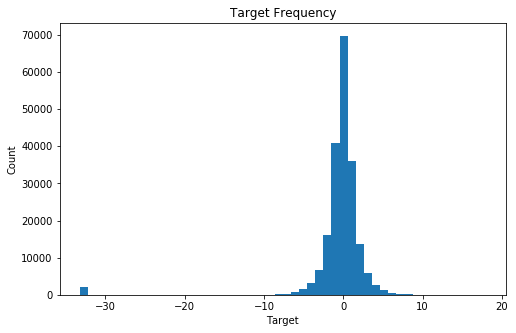

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(train.target.values, bins=50)
plt.title('Target Frequency')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


/home/khanna/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


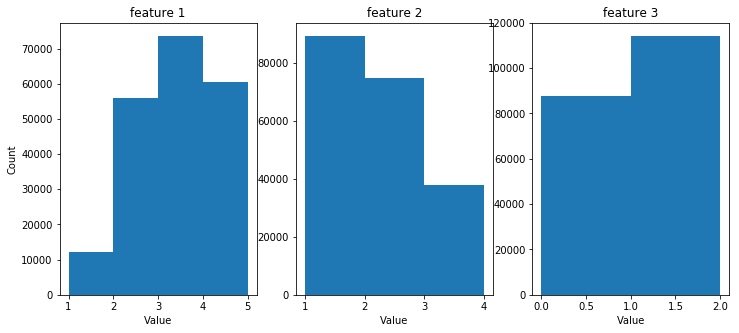

In [7]:

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12.0, 5.0))

ax1.hist(train.feature_1.values, bins=[1,2,3,4,5])
ax1.set_title('feature 1')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

ax2.hist(train.feature_2.values, bins=[1,2,3,4])
ax2.set_title('feature 2')
ax2.set_xlabel('Value')
# ax2.set_ylabel('Count')

ax3.hist(train.feature_3.values, bins=[0,1,2])
ax3.set_title('feature 3')
ax3.set_xlabel('Value')
# ax3.set_ylabel('Count')

fig1.show()

# Model
## Baseline

Our baseline model uses the data provided in the "train" dataset. 

In [8]:
def calculate_baseline():
    training = train[['feature_1', 'feature_2', 'feature_3']]
    labels = train[['target']]

    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    test_data = training.values[~mask]
    test_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("After fitting Linear Regression, the baseline Mean Squared Error is: {:0.3f}".format(mse))
    print("The mean of our training label is {:0.3f} and for testing {:0.3f}".format(y_mean, y_test_mean))
    
    return mse

baseline_mse = calculate_baseline()

After fitting Linear Regression, the baseline Mean Squared Error is: 14.269
The mean of our training label is -0.394 and for testing -0.393


# Feature Engineering

## Transform train first_active_month to numeric
The first_active_month is a date the shopper first made a purchase using Elo.  Converting this to days would make it more useful for modelling. 

In [9]:
def first_active_month_to_numeric():
    global train, test
    latest_date = max(train['first_active_month'].max(), test['first_active_month'].max()) + timedelta(days=1)
    train['first_active_delta_days'] = ((latest_date - train['first_active_month']).dt.days)
    test['first_active_delta_days']  = ((latest_date - test['first_active_month']).dt.days)

first_active_month_to_numeric()

# we no longer need first active month
del train['first_active_month']

# display(train.head())
# display(test.head())



## Binarize 'Y' and 'N' category
Convert to binary so they can be aggregated later. 

In [10]:
transactions_old['category_1'] = transactions_old.category_1.eq('Y').mul(1)
transactions_new['category_1'] = transactions_new.category_1.eq('Y').mul(1)

transactions_old['authorized_flag_y'] = transactions_old.authorized_flag.eq('Y').mul(1)
transactions_new['authorized_flag_y'] = transactions_new.authorized_flag.eq('Y').mul(1)

transactions_old['authorized_flag_n'] = transactions_old.authorized_flag.eq('N').mul(1)
transactions_new['authorized_flag_n'] = transactions_new.authorized_flag.eq('N').mul(1)

## Create some dummy variables

In [11]:
train = pd.get_dummies(train, columns=['feature_1', 'feature_2'])
test = pd.get_dummies(test, columns=['feature_1', 'feature_2'])
transactions_old = pd.get_dummies(transactions_old, columns=['category_2', 'category_3'])
transactions_new = pd.get_dummies(transactions_new, columns=['category_2', 'category_3'])

# display(train.head())
# display(test.head())
# display(transactions_old.head())
# display(transactions_new.head())

## Create New Features
Need a better subtitle :) 

In [12]:
transactions_old['month_diff'] = ((datetime.today() - transactions_old['purchase_date']).dt.days)//30
transactions_old['month_diff'] += transactions_old['month_lag']

transactions_new['month_diff'] = ((datetime.today() - transactions_new['purchase_date']).dt.days)//30
transactions_new['month_diff'] += transactions_new['month_lag']



## Aggregate New and Old Transactions with Train on `card_id` 
see: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

In [13]:
def aggregate_data():
    global train, test
    
    # These aggregations will be performed on both new and old
    aggregation = {
#         'purchase_amount': ['sum', 'mean', 'median', 'max', 'min', 'std'],
        'purchase_amount': ['sum', 'mean', 'median'],
        'subsector_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'state_id': ['nunique'], 
        'category_1': ['sum'],
        'category_2_1.0': ['sum'],
        'category_2_2.0': ['sum'],
        'category_2_3.0': ['sum'],
        'category_2_4.0': ['sum'],
        'category_2_5.0': ['sum'],
        'category_3_A': ['sum'],
        'category_3_B': ['sum'],
        'category_3_C': ['sum'],
        'authorized_flag_y': ['sum'],
        'authorized_flag_n': ['sum'],
        'month_diff': ['mean', 'min', 'max', 'std']
        
    }
    
    # Do aggregations on aggregated_old and join with training and test data
    aggregated_old = transactions_old.groupby(['card_id']).agg(aggregation)
    aggregated_old.columns = ['old_' + '_'.join(col).strip() for col in aggregated_old.columns.values]
    train = train.merge(right=aggregated_old, how='left', on='card_id')
    test = test.merge(right=aggregated_old, how='left', on='card_id')

    # Do aggregations on aggregated_new and join with training and test data
    aggregated_new = transactions_new.groupby(['card_id']).agg(aggregation)
    aggregated_new.columns = ['new_' + '_'.join(col).strip() for col in aggregated_new.columns.values]
    train = train.merge(right=aggregated_new, how='left', on='card_id')
    test = test.merge(right=aggregated_new, how='left', on='card_id')
    
    # Joining the transaction_new with train created some empty cells
    # Fill them with zeros
    train = train.fillna(0)
    test = test.fillna(0)

    
aggregate_data()
# display(train.head())
# display(test.head())

## A view of our new training data dataframe

In [67]:
display(train.head())
display(test.head())

,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,...,new_category_2_5.0_sum,new_category_3_A_sum,new_category_3_B_sum,new_category_3_C_sum,new_authorized_flag_y_sum,new_authorized_flag_n_sum,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_std
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,1,246,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,23.0,0.0,0.0,23.0,0.0,13.523438,13.0,14.0,0.510742
C_ID_3d0044924f,0,397,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,6.0,0.0,6.0,0.0,14.500000,14.0,15.0,0.547852
C_ID_d639edf6cd,0,550,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,13.000000,13.0,13.0,0.000000
C_ID_186d6a6901,0,154,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,6.0,0.0,7.0,0.0,13.570312,13.0,14.0,0.534668
C_ID_cdbd2c0db2,0,93,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,34.0,1.0,36.0,0.0,13.585938,13.0,14.0,0.500000


,first_active_month,feature_3,first_active_delta_days,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,...,new_category_2_5.0_sum,new_category_3_A_sum,new_category_3_B_sum,new_category_3_C_sum,new_authorized_flag_y_sum,new_authorized_flag_n_sum,new_month_diff_mean,new_month_diff_min,new_month_diff_max,new_month_diff_std
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,2017-04-01,1,307,0,0,1,0,0,0,0,...,0.0,0.0,2.0,1.0,3.0,0.0,15.333333,15.0,16.0,0.577350
C_ID_130fd0cbdd,2017-01-01,0,397,0,1,0,0,0,0,0,...,0.0,0.0,8.0,1.0,9.0,0.0,13.777778,13.0,14.0,0.440959
C_ID_b709037bc5,2017-08-01,1,185,0,0,0,0,1,1,0,...,1.0,0.0,1.0,1.0,2.0,0.0,14.000000,14.0,14.0,0.000000
C_ID_d27d835a9f,2017-12-01,0,63,0,1,0,0,0,1,0,...,1.0,0.0,5.0,5.0,10.0,0.0,13.600000,13.0,14.0,0.516398
C_ID_2b5e3df5c2,2015-12-01,1,794,0,0,0,0,1,1,0,...,0.0,0.0,4.0,1.0,6.0,0.0,14.000000,14.0,14.0,0.000000


# Feature Extraction
Analyze and select features for modeling

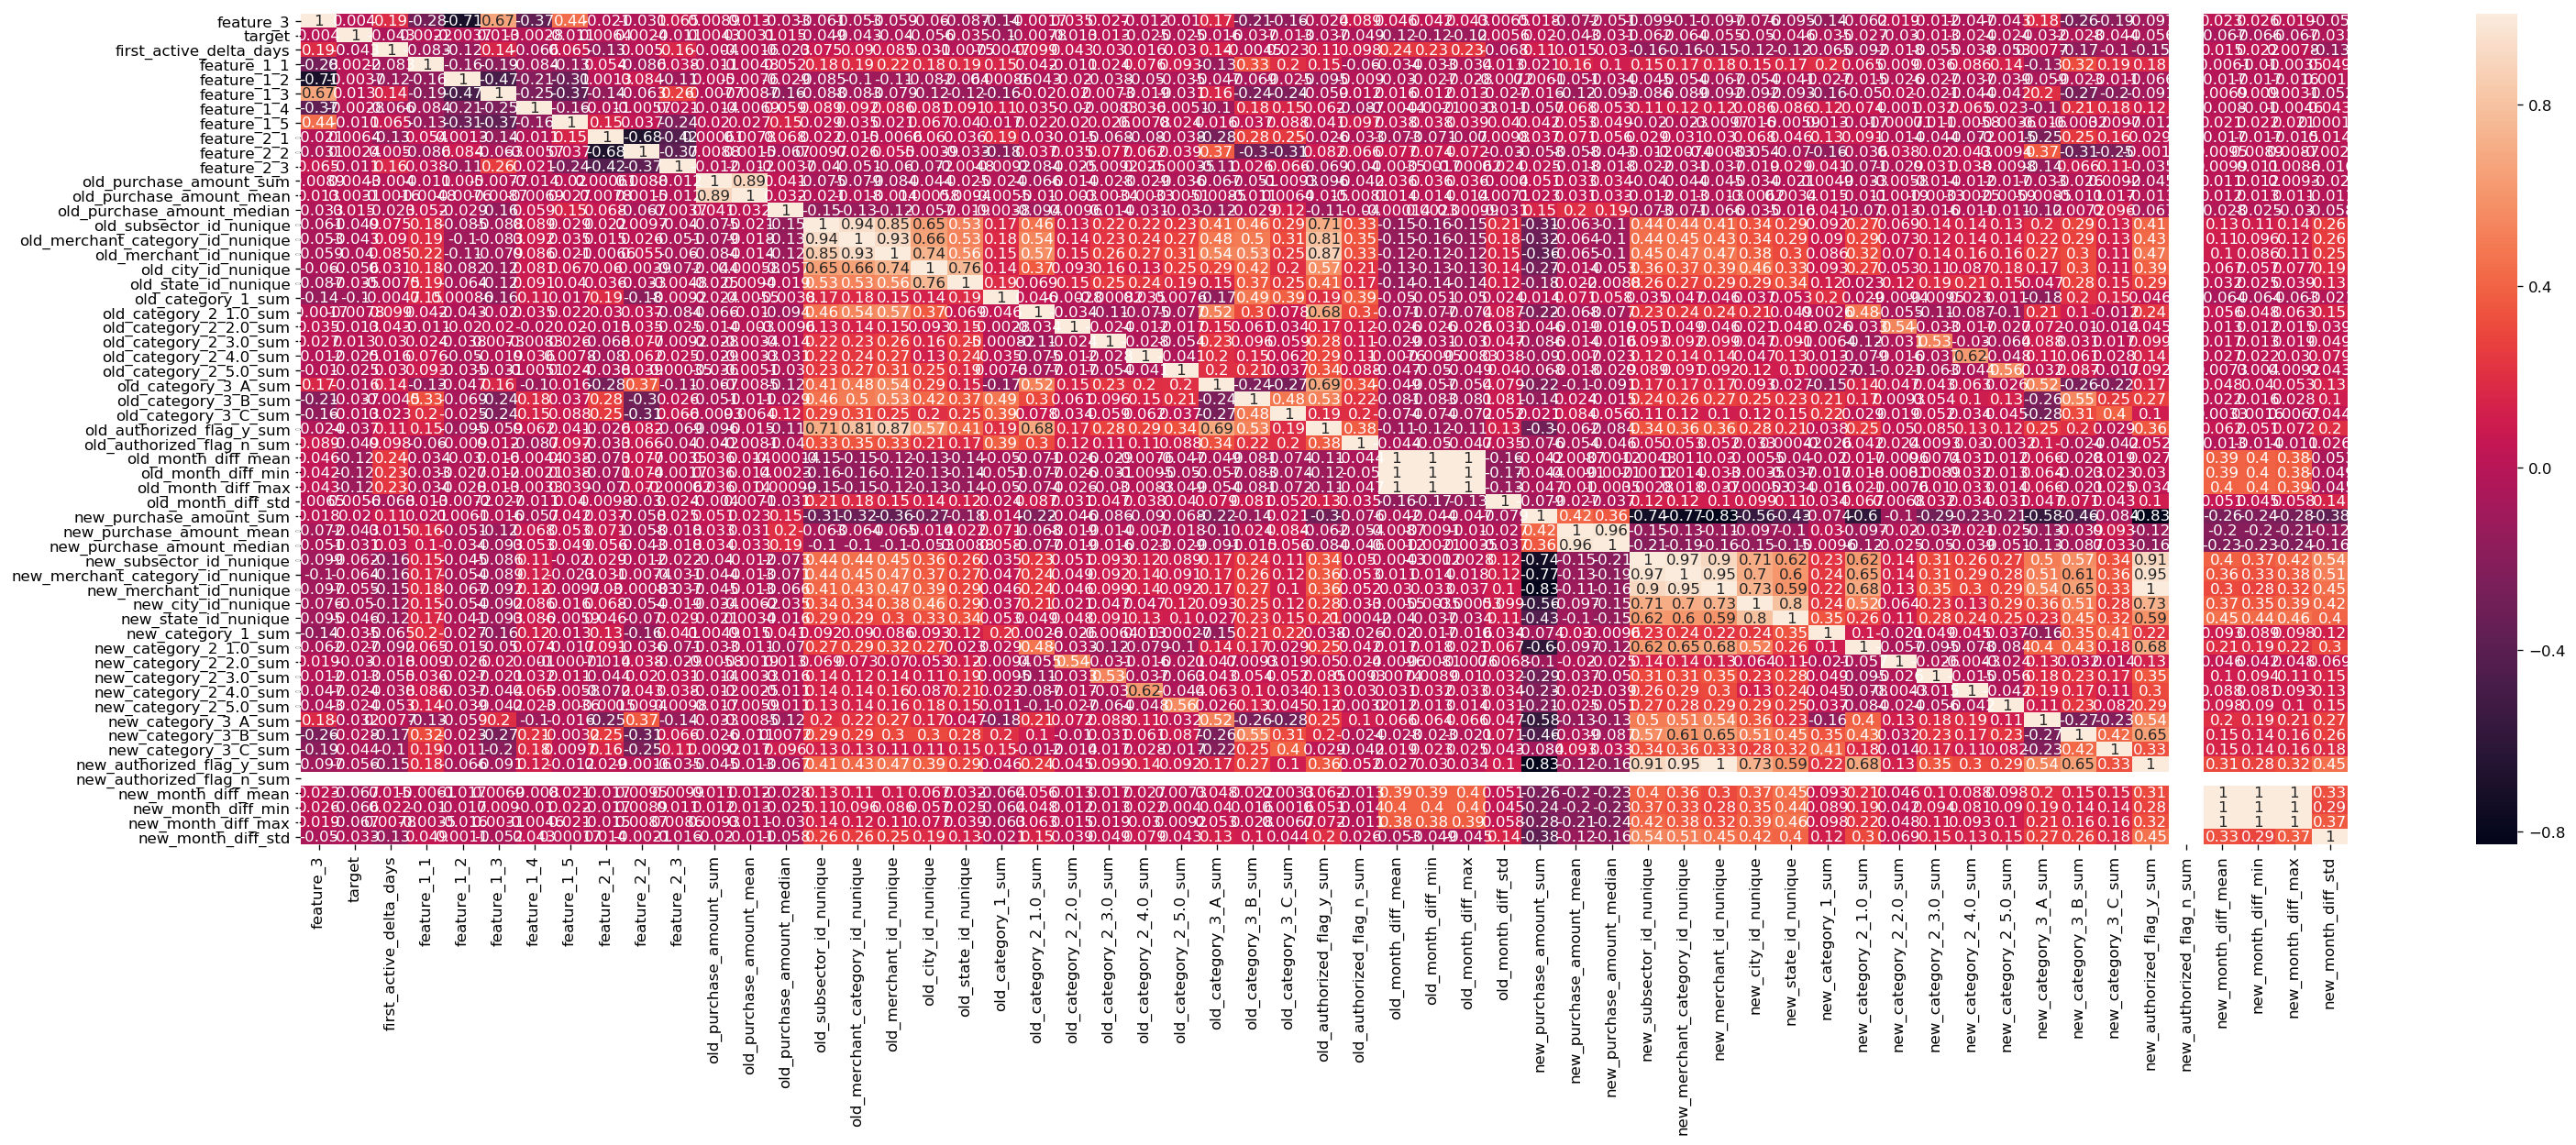

In [14]:
train_sm = train[train.columns[1:]][:5000]
corr = train_sm.corr()
plt.figure(num=None, figsize=(30,10), dpi=120, facecolor='w', edgecolor='k')
sb.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True
          )

# Note the strong negative correlations to new_purchase_amount_sum. 
# I suspect this is because of the zero filled values when we joined
# train with transactions_new (which don't line up 1:1)

# When we reduce features this will be less ugly again

In [15]:
train_sm = train[train.columns[1:]][:10]
cov = np.cov(train_sm, ddof=1)
display(pd.DataFrame(cov))


,0,1,2,3,4,5,6,7,8,9
0,4815.806409,5065.360941,2659.278006,1149.811008,1065.175407,2386.225820,4397.214258,848.004306,853.615740,3865.317059
1,5065.360941,8609.427945,3961.876556,2071.504169,2150.858400,3881.254944,4804.925510,1177.488143,1429.097688,5143.276642
2,2659.278006,3961.876556,5345.425706,1499.309119,882.424904,4974.303846,4598.835974,1493.055776,1772.148465,5401.070074
3,1149.811008,2071.504169,1499.309119,700.733890,711.269553,1424.299184,1553.303038,454.997047,525.153099,1658.723432
4,1065.175407,2150.858400,882.424904,711.269553,990.880281,844.722113,1239.988298,300.728044,328.436889,1090.769479
5,2386.225820,3881.254944,4974.303846,1424.299184,844.722113,4719.243211,3908.115122,1398.663916,1682.973229,5042.250701
6,4397.214258,4804.925510,4598.835974,1553.303038,1239.988298,3908.115122,6973.949407,1311.035828,1394.412302,5116.157187
7,848.004306,1177.488143,1493.055776,454.997047,300.728044,1398.663916,1311.035828,439.167861,504.764516,1547.858362
8,853.615740,1429.097688,1772.148465,525.153099,328.436889,1682.973229,1394.412302,504.764516,607.833821,1797.408654
9,3865.317059,5143.276642,5401.070074,1658.723432,1090.769479,5042.250701,5116.157187,1547.858362,1797.408654,5901.990659


## Train and test model using ALL engineered features 

In [16]:
def calculate_engineered():
    np.random.seed(0)
    training = train[train.columns[1:]]
    del training['target']
    labels = train[['target']]
    
    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    test_data = training.values[~mask]
    test_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("After doing feature enginnering, the Mean Squared Error is: {:0.3f}".format(mse))
    
    return mse


engineered_mse = calculate_engineered()

After doing feature enginnering, the Mean Squared Error is: 13.897


In [17]:
delta_from_baseline = baseline_mse - engineered_mse
print("Our MSE of {:0.3f} is a change of {:0.3f} from our baseline MSE of {:0.3f}".format(engineered_mse, delta_from_baseline, baseline_mse))

Our MSE of 13.897 is a change of 0.372 from our baseline MSE of 14.269


In [18]:
train.columns

Index(['first_active_month', 'feature_3', 'target', 'first_active_delta_days',
       'feature_1_1', 'feature_1_2', 'feature_1_3', 'feature_1_4',
       'feature_1_5', 'feature_2_1', 'feature_2_2', 'feature_2_3',
       'old_purchase_amount_sum', 'old_purchase_amount_mean',
       'old_purchase_amount_median', 'old_subsector_id_nunique',
       'old_merchant_category_id_nunique', 'old_merchant_id_nunique',
       'old_city_id_nunique', 'old_state_id_nunique', 'old_category_1_sum',
       'old_category_2_1.0_sum', 'old_category_2_2.0_sum',
       'old_category_2_3.0_sum', 'old_category_2_4.0_sum',
       'old_category_2_5.0_sum', 'old_category_3_A_sum',
       'old_category_3_B_sum', 'old_category_3_C_sum',
       'old_authorized_flag_y_sum', 'old_authorized_flag_n_sum',
       'old_month_diff_mean', 'old_month_diff_min', 'old_month_diff_max',
       'old_month_diff_std', 'new_purchase_amount_sum',
       'new_purchase_amount_mean', 'new_purchase_amount_median',
       'new_subsector_id

## Test area to play with different sets of features

In [20]:
def feature_play():
    np.random.seed(0)
    #This is just to play around with different engineered features. 

    
    training = train[[
        # Train
        'feature_3',
        'first_active_delta_days',
        'feature_1_1', 
        'feature_1_2', 
        'feature_1_3', 
        'feature_1_4',
        'feature_1_5', 
        'feature_2_1', 
        'feature_2_2', 
        'feature_2_3',
        
        # Old
        'old_purchase_amount_sum', 
        'old_purchase_amount_mean',
#         'old_purchase_amount_median', # Mean is better than Median
        'old_subsector_id_nunique',
        'old_merchant_category_id_nunique', 
        'old_merchant_id_nunique',
        'old_city_id_nunique', 
        'old_state_id_nunique', 
        'old_category_1_sum',
        'old_category_2_1.0_sum', 
        'old_category_2_2.0_sum',
        'old_category_2_3.0_sum', 
        'old_category_2_4.0_sum',
        'old_category_2_5.0_sum', 
        'old_category_3_A_sum',
        'old_category_3_B_sum', 
        'old_category_3_C_sum',
        'old_authorized_flag_y_sum',
        'old_authorized_flag_n_sum',
        'old_month_diff_mean', 
        'old_month_diff_min', 
        'old_month_diff_max',
        'old_month_diff_std',
        
        # New
        'new_purchase_amount_sum', 
        'new_purchase_amount_mean',
#         'new_purchase_amount_median', 
        'new_subsector_id_nunique',
        'new_merchant_category_id_nunique', 
        'new_merchant_id_nunique',
        'new_city_id_nunique', 
        'new_state_id_nunique', 
        'new_category_1_sum',
        'new_category_2_1.0_sum', 
        'new_category_2_2.0_sum',
        'new_category_2_3.0_sum', 
        'new_category_2_4.0_sum',
        'new_category_2_5.0_sum', 
        'new_category_3_A_sum',
        'new_category_3_B_sum', 
        'new_category_3_C_sum',
        'new_authorized_flag_y_sum',
        'new_authorized_flag_n_sum',
        'new_month_diff_mean', 
        'new_month_diff_min', 
        'new_month_diff_max',
        'new_month_diff_std'
    ]]
    
    
    labels = train[['target']]
    
    data_len = len(training)
    mask = np.random.rand(data_len) < 0.8

    train_data = training.values[mask]
    train_labels = labels.values.flatten()[mask]
    test_data = training.values[~mask]
    test_labels = labels.values.flatten()[~mask]

    X = train_data
    y = train_labels

    X_test = test_data
    y_test = test_labels

    reg = LinearRegression()
    reg.fit(X, y)

    y_pred_reg = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_reg)

    y_mean = train_labels.mean()
    y_test_mean = test_labels.mean()

    print("Using the following features, the Mean Squared Error is: {:0.3f}".format(mse))
    print(training.columns)
    
    return mse

# if play_mse:
#     print("Previous MSE: {:0.3f}".format(play_mse))
    
play_mse = feature_play()

Using the following features, the Mean Squared Error is: 13.884
Index(['feature_3', 'first_active_delta_days', 'feature_1_1', 'feature_1_2',
       'feature_1_3', 'feature_1_4', 'feature_1_5', 'feature_2_1',
       'feature_2_2', 'feature_2_3', 'old_purchase_amount_sum',
       'old_purchase_amount_mean', 'old_subsector_id_nunique',
       'old_merchant_category_id_nunique', 'old_merchant_id_nunique',
       'old_city_id_nunique', 'old_state_id_nunique', 'old_category_1_sum',
       'old_category_2_1.0_sum', 'old_category_2_2.0_sum',
       'old_category_2_3.0_sum', 'old_category_2_4.0_sum',
       'old_category_2_5.0_sum', 'old_category_3_A_sum',
       'old_category_3_B_sum', 'old_category_3_C_sum',
       'old_authorized_flag_y_sum', 'old_authorized_flag_n_sum',
       'old_month_diff_mean', 'old_month_diff_min', 'old_month_diff_max',
       'old_month_diff_std', 'new_purchase_amount_sum',
       'new_purchase_amount_mean', 'new_subsector_id_nunique',
       'new_merchant_category_i

In [45]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [62]:
train_copy = train.copy()

In [63]:
train = train_copy.copy()

del train['first_active_month']

train = reduce_mem_usage(train)

target = train['target']
del train['target']

features = [c for c in train.columns if 'target' not in c]
categorical_feats = [c for c in features if 'feature_' in c]


# target = reduce_mem_usage(target)
# features = reduce_mem_usage(features)
# categorical_feats = reduce_mem_usage(categorical_feats)
# categorical_feats = categorical_feats.astype('bool')

# display(target)

Mem. usage decreased to 22.92 Mb (70.8% reduction)


In [65]:
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1
         ):
    
    ### Delete this
   
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats)
    
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'rmse',
            "lambda_l1": lambda_l1,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(train.iloc[val_idx][features],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, target)**0.5

In [50]:
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 1.0),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 6)
    })

In [51]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))



In [66]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('-'*126)

start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)
timer(start_time)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------


AttributeError: 'list' object has no attribute 'shape'